In [ ]:
__author__"Emily Hua"

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
ls -l

total 2518576
-rw-r--r--  1 yehua  staff         72 Nov  9 15:29 Untitled.ipynb
-rw-r--r--@ 1 yehua  staff  706621807 Nov  9 17:57 checkin_usersGPS_largcomp_index.csv
-rw-r--r--@ 1 yehua  staff  424684270 Nov  4 09:49 checkin_usersGPS_largcomp_training.csv
-rw-r--r--  1 yehua  staff   86643814 Nov  4 14:35 checkin_usersGPS_largcomp_training.csv.zip
-rw-r--r--  1 yehua  staff      28802 Nov  9 20:32 socialntworkTA-Copy1.ipynb
-rw-r--r--  1 yehua  staff     325413 Nov  9 20:49 socialntworkTA.ipynb
-rw-r--r--  1 yehua  staff    9273604 Nov  9 17:38 usersGPS_larg_comp_index.txt
-rw-r--r--@ 1 yehua  staff    5992511 Nov  4 09:46 usersGPS_larg_comp_training.txt
-rw-r--r--  1 yehua  staff    1885326 Nov  4 14:34 usersGPS_larg_comp_training.txt.zip
-rw-r--r--@ 1 yehua  staff    1128631 Nov  9 12:12 usersGPS_test_coeff.txt
-rw-r--r--@ 1 yehua  staff    1128631 Nov  9 12:10 usersGPS_test_degree.txt
-rw-r--r--  1 yehua  staff   31254665 Nov  9 13:28 usersGPS_test_serverData2.txt
-rw-r--r--@ 1 yeh

load check-in data

In [4]:
df_checkin = pd.read_csv("checkin_usersGPS_largcomp_index.csv", header=None)

In [5]:
df_checkin.columns = ['node', 'latitude', 'logitude','epoch']

In [6]:
df_checkin.shape

(16345312, 4)

In [7]:
df_checkin['node'] = df_checkin['node'].astype(int)

In [8]:
df_checkin['date'] = pd.to_datetime(df_checkin['epoch'],unit='s')

In [9]:
#I don't want to look at the epoch time anymore
del df_checkin['epoch']

In [240]:
#preview first 2 entries
df_checkin[:2]

,node,latitude,logitude,date
0,6200,40.82942,-73.920529,2013-08-31 20:45:49
1,6200,40.82942,-73.920529,2013-08-31 20:42:34


keep the last check-in 

In [11]:
idx = df_checkin.groupby(['node'])['date'].transform(max) == df_checkin['date']
#print (idx)
df_last_checkin = df_checkin[idx]

In [12]:
#checking node 6200
df_last_checkin[df_last_checkin['node'] == 6200]

,node,latitude,logitude,date
12955901,6200,19.050797,-98.283927,2013-09-06 04:36:41


load the edges 

In [14]:
df_edges = pd.read_csv("usersGPS_larg_comp_index.txt",sep=" ", header=None)

In [15]:
df_edges.columns = ['node1','node2']

In [16]:
df_edges.shape

(850158, 2)

In [17]:
#preview first two rows
df_edges[:2]

,node1,node2
0,0,1
1,0,2


undirected graph

In [18]:
G=nx.from_pandas_dataframe(df_edges, 'node1', 'node2')

In [19]:
#takes freaking long time to return
#print(nx.average_shortest_path_length(G))

Greedy Routing

In [20]:
source_node = 939
target_node = 27878

In [278]:
#uses Euclidean distance squared
def greedy_routing(G, source_node, target_node, checkin, df_degree):
    import sys
    target_la = checkin['latitude'][checkin['node']==target_node].tolist()
    target_lo = checkin['logitude'][checkin['node']==target_node].tolist()
    target_geo = np.array([target_la, target_lo]).T
    print ("target_geo ", target_geo)
    counter = 0
    prev_distance = sys.maxsize
    visited_node = []
    while ( target_node not in G.neighbors(source_node)):
        visited_node.append(source_node)
        neighbors = G.neighbors(source_node)
        #now only return the half of the neighbors with highest degree
        neighbors = return_half_top_degree_neighbors(df_degree, neighbors)
        df_nodes = checkin[checkin['node'].isin(neighbors)] 
        geo_lists = [] #constains the latitude and logitude of the neighbors geo info from check-in
        for i in range(0, len(df_nodes)):
            geo_list = [df_nodes.iloc[i]['latitude'], df_nodes.iloc[i]['logitude']]
            geo_lists.append(geo_list)
        geo_lists = np.array(geo_lists)
        distance = (target_geo - geo_lists)**2
        distance = distance.sum(axis = 1)
        min_index, local_min_distance = get_min_dis_node_index(distance, prev_distance, visited_node, df_nodes)   
        prev_distance = local_min_distance
        source_node = df_nodes.iloc[min_index].tolist()[0]
        print ("new source node: ", source_node)
        counter += 1
        if (counter > 200) :
            break
        
    print ("source_node: ", source_node)
    print (counter)
    

In [279]:
def get_min_dis_node_index(distance, pre_distance, visited_node, df_nodes):
    import sys
    from random import randint
    local_min_distance = sys.maxsize
    index = randint(0,len(distance) -1)
    for i in range(len(distance)):
                                            #avoid self-loop
        if (distance[i] <= local_min_distance and distance[i] != pre_distance and df_nodes.iloc[i].tolist()[0] not in visited_node):
            local_min_distance = distance[i]
            index = i  
    return (index, local_min_distance)
        

In [280]:
def return_half_top_degree_neighbors(df_degree, neighbors):
    import math
    df_neighbors = df_degree[df_degree['node'].isin (neighbors)]
    #look at top 50% 
    df_neighbors = df_neighbors.sort_values(by = ['degree'], ascending=False)
    top_degree_neighbors = []
    for i in range(math.ceil(df_neighbors.shape[0]/2)):
        top_degree_neighbors.append(df_neighbors['node'].iloc[i])
    return top_degree_neighbors

In [281]:
#57	87575
source_node = 1175
target_node = 6573#6573#22300#59202#20526#63560#59202#23604#44204  #64884#71116#41916#13299#78126
greedy_routing(G, source_node, target_node, df_last_checkin, df_degree)

target_geo  [[  39.04260259 -122.91504849]]
new source node:  9802
new source node:  1897
new source node:  26631
new source node:  10800
new source node:  1413
new source node:  52060
new source node:  330
new source node:  37743
new source node:  12953
new source node:  33238
new source node:  109
new source node:  9800
new source node:  2293
new source node:  14297
new source node:  6795
new source node:  38639
new source node:  497
new source node:  15071
new source node:  4856
new source node:  20496
new source node:  2078
new source node:  22753
new source node:  472
new source node:  13811
new source node:  4554
new source node:  31257
new source node:  6092
new source node:  26
source_node:  26
28


In [282]:
#sanity check
6573 in G.neighbors(26)

True

In [237]:
source_node = 836
target_node = 111#6573#22300#59202#20526#63560#59202#23604#44204  #64884#71116#41916#13299#78126
greedy_routing(G, source_node, target_node, df_last_checkin, df_degree)

target_geo  [[ 59.98536744  30.28854983]]
new source node:  40576
new source node:  3098
new source node:  21611
new source node:  2040
new source node:  35882
new source node:  1297
new source node:  22220
source_node:  22220
7


In [196]:
#how to check if a node in the neighbors of another node? 
6573 in G.neighbors(26)

True

regression on testing the significance of degree and local_clustering_coefficient on the length of shortest path 

In [24]:
df_coef = pd.read_csv("usersGPS_test_coeff.txt", sep=":", header = None)
df_coef.columns = ['node', 'coef']

In [25]:
df_coef[:3]

,node,coef
0,0,0.01
1,1,0.00
2,2,0.01


In [26]:
df_degree = pd.read_csv("usersGPS_test_degree.txt",  sep=":", header = None)
df_degree.columns = ['node', 'degree']

In [27]:
df_degree[:3]

,node,degree
0,0,25
1,1,329
2,2,445


In [29]:
#switch to numpy array, no need actually...
#df_s_degree = df_degree.as_matrix()
#df_s_coef = df_coef.as_matrix()

In [34]:
# number of distinct node in graph is 87586
import random
n = 100
sel = random.sample(range(87586), n)
print (sel)

[87202, 30309, 62870, 86499, 84917, 8204, 63291, 14880, 20974, 43614, 63097, 54561, 80554, 15477, 55149, 74634, 12960, 35709, 79356, 27039, 61526, 64674, 18822, 20484, 85245, 26808, 27671, 58360, 75681, 57806, 18464, 72589, 45194, 39973, 9941, 35589, 83168, 78270, 19029, 86311, 61401, 56229, 51783, 42420, 30718, 61423, 57130, 46318, 60495, 22669, 40166, 8963, 71731, 20066, 30741, 48501, 70625, 60181, 78661, 23683, 20942, 84293, 63245, 34768, 65227, 10747, 57697, 74311, 61319, 44445, 67994, 14528, 61744, 21816, 15813, 37719, 35149, 37325, 60307, 29258, 64090, 10425, 30646, 78557, 21484, 18492, 6888, 25564, 79999, 55864, 36691, 6860, 27522, 22255, 41749, 73624, 26340, 18702, 7288, 63519]


In [35]:
import random
n = 100
sel1 = random.sample(range(5000), n)
print (sel1)

[2374, 2610, 75, 3999, 178, 1405, 3679, 2235, 4791, 4431, 1878, 3539, 3768, 3218, 1111, 3940, 3350, 3070, 1802, 4844, 2731, 2738, 4627, 227, 128, 3291, 1661, 4347, 147, 4038, 852, 126, 2223, 3734, 444, 1362, 1389, 4915, 2225, 2905, 1569, 3811, 639, 3927, 261, 4942, 1664, 713, 2439, 3287, 3783, 3397, 1620, 1226, 2775, 999, 1249, 1143, 813, 4680, 3973, 3897, 2747, 4774, 3228, 1896, 2677, 3646, 4201, 3763, 1416, 4778, 1246, 4650, 1268, 3470, 4467, 566, 4459, 4387, 4169, 461, 111, 4535, 3653, 2109, 795, 1228, 4264, 2536, 2692, 1748, 4450, 4274, 548, 576, 3247, 2640, 3030, 945]


In [36]:
#generate 10000 node pairs as source-target
source_target_list = []
for i in sel:
    for j in sel1:
        source_target_list.append([i, j])
print (len(source_target_list))
        

10000


In [37]:
#calculate their shortest path length through networkx
shortest_path_length = []
for i in range(len(source_target_list)):
    shortest_path_length.append(nx.shortest_path_length(G,source_target_list[i][0], source_target_list[i][1] ))

In [156]:
#get the degree of a particular node
df_degree['degree'][df_degree['node'] == source_target_list[1][0]].tolist()[0]

4

In [157]:
df_coef['coef'][df_coef['node'] == source_target_list[1][0]].tolist()[0]

0.0

In [38]:
degree_list = [] #stores average degree of intermediary nodes (+source+target)
coef_list = []#stores average coef of intermediary nodes (+source+target)
for i in range(len(source_target_list)):
    neigh = nx.shortest_path(G,source_target_list[i][0], source_target_list[i][1] )
    degree_sum = 0
    coef_sum = 0
    for j in neigh:
        degree_sum += df_degree['degree'][df_degree['node'] == j].tolist()[0]
        coef_sum += df_coef['coef'][df_coef['node'] == j].tolist()[0]
    degree_avg = degree_sum/len(neigh)
    coef_avg = coef_sum/len(neigh)
    degree_list.append(degree_avg)
    coef_list.append(coef_avg)
    if (i % 50 == 0 ):
        print (i)
    

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950


In [244]:
degree_list[:5]
print (len(degree_list))

10000


In [245]:
coef_list[:5]
print (len(coef_list))

10000


In [45]:
shortest_path_length[:5]
print (len(shortest_path_length))

10000


In [51]:
#combine three lists into one pandas data frame
regression_list = pd.DataFrame(
    {'length': shortest_path_length,
     'degree': degree_list,
     'coef': coef_list
    })

In [52]:
regression_list[:5] #preview first 5 rows

,coef,degree,length
0,0.002857,384.428571,6
1,0.010000,446.166667,5
2,0.001429,92.857143,6
3,0.015714,58.714286,6
4,0.004286,23.428571,6


In [54]:
#OLS regression
from statsmodels.formula.api import ols
import statsmodels.api as sm

result = ols('length ~ coef + degree', data = regression_list).fit()
print (result.params)
print ("correlation: ", regression_list['length'].corr(regression_list['degree']))
print (result.summary())

Intercept    3.569074
coef         2.654647
degree      -0.000476
dtype: float64
correlation:  -0.184399550459
                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     226.9
Date:                Wed, 09 Nov 2016   Prob (F-statistic):           4.40e-97
Time:                        21:13:35   Log-Likelihood:                -10737.
No. Observations:               10000   AIC:                         2.148e+04
Df Residuals:                    9997   BIC:                         2.150e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------

use robust standard error to avoid heteroskedasticity

In [248]:
results_robust = result.get_robustcov_results(cov_type='HC1')
print(results_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     219.8
Date:                Thu, 10 Nov 2016   Prob (F-statistic):           3.86e-94
Time:                        16:22:19   Log-Likelihood:                -10737.
No. Observations:               10000   AIC:                         2.148e+04
Df Residuals:                    9997   BIC:                         2.150e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.5691      0.013    278.049      0.0

regression plotting

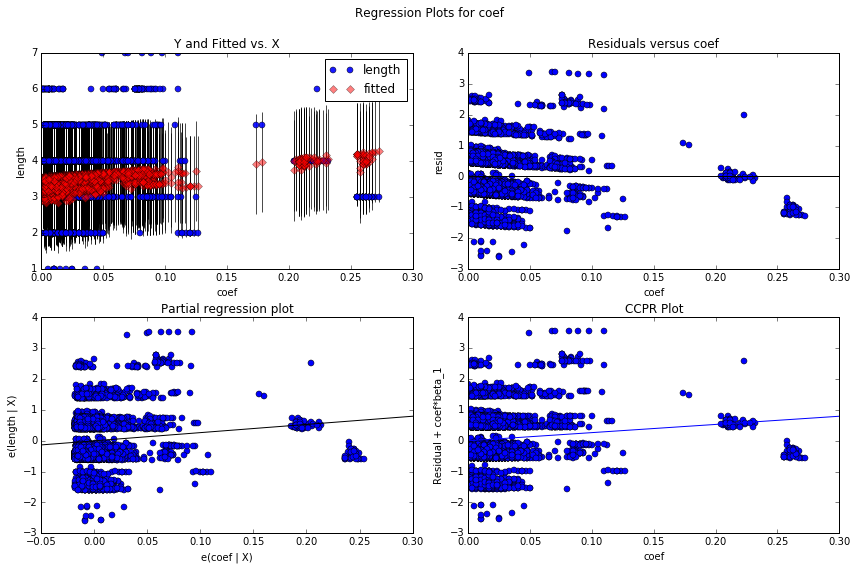

In [254]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results_robust, "coef", fig=fig)

coef has high variance 

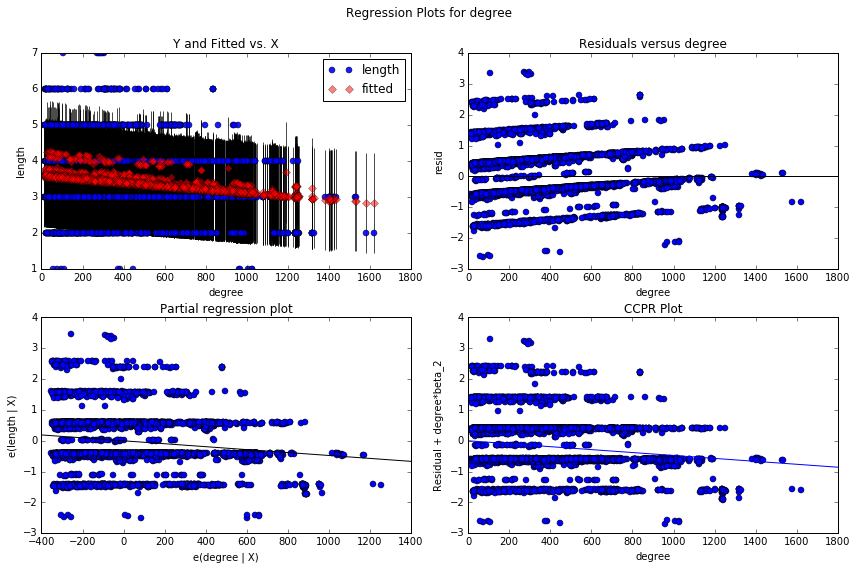

In [253]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(results_robust, "degree", fig=fig)

scratch code

In [20]:
source_node = 20750
neighbors = G.neighbors(source_node)
#print("node: ", source_node, "neighbors: ", neighbors)
df_nodes = df_last_checkin[df_last_checkin['node'].isin(neighbors)]


In [22]:
df_nodes[:5]

,node,latitude,logitude,date
55275,319,38.1629,14.7449,2013-08-15 23:03:51
61470,338,34.1359,-118.2151,2013-09-04 02:07:12
61859,341,40.7565,-73.9863,2013-06-26 05:52:01
67427,367,41.7637,-87.8035,2013-09-01 19:40:18
73632,398,34.0947,-117.5887,2013-07-07 18:06:19


In [278]:
distance =np.array([ 8, 32, 0])

In [279]:
min_distance(distance)

0

In [280]:
(13.7542-38.1629)**2 + (100.5646-14.7449)**2

7960.805543779999

In [225]:
a = np.array([[ 1,  2]])
b = np.array([[  3 , 4],[ 5 , 6]])
print (a)
print(b)
distance = (a-b)**2
print("distance: ", distance)
distance = distance.sum(axis=1)
print("index: ", distance.argmax())
print ("distance: ", distance)

[[1 2]]
[[3 4]
 [5 6]]
distance:  [[ 4  4]
 [16 16]]
index:  1
distance:  [ 8 32]


In [151]:
df_last_checkin['latitude'].loc[df_last_checkin['node'] == target_node].tolist()

[45.7881]

In [152]:
df_last_checkin['logitude'][df_last_checkin['node'] == target_node].tolist()

[3.0992999999999999]

In [148]:
np.linalg.norm(45.7881-
               3.0993)

42.688800000000001

In [296]:
df_last_checkin[df_last_checkin['node']==939]

,node,latitude,logitude,date
215991,939,58.3649,11.259,2012-09-13 19:12:30


In [26]:
df_edges.shape

(558149, 2)

In [ ]:
600

In [246]:
'''
#find the node pair that have shortest path at least 6
t = 0
for i in range(143 , 47708 ):
    for j in range(47708):
        length = nx.shortest_path_length(G, i, j)
        if (length > 6):
            print (i,j, length)
            break;
        t += 1
        if (t >= 47708**2):
            break;
'''       

'\n#find the node pair that have shortest path at least 6\nt = 0\nfor i in range(143 , 47708 ):\n    for j in range(47708):\n        length = nx.shortest_path_length(G, i, j)\n        if (length > 6):\n            print (i,j, length)\n            break;\n        t += 1\n        if (t >= 47708**2):\n            break;\n'

In [247]:
nx.shortest_path_length(G, 11, 7061)

3